In [2]:
import os
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import readsav
import matplotlib.pyplot as plt
from astropy import units as u
from matplotlib.colors import LinearSegmentedColormap

COLOR='white'

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

In [19]:
parula_colors = np.load('/Users/arcticfox/parula_colors.npy')
mdir = '/Users/arcticfox/Documents/atmospheres/v1298tau/marshall_plots/planetc'
files = np.sort([os.path.join(mdir, i) for i in os.listdir(mdir) if i.endswith('.sav')])

In [20]:
def hex_to_rgb(h):
    if '#' in h:
        h = h.lstrip('#')   
    hlen = int(len(h))
    rgb = tuple(int(h[i:int(i+hlen/3)], 16) / 255.0 for i in range(0, hlen, int(hlen/3)))
    return rgb

In [21]:
print(files[-1])
data = readsav(files[-1])

/Users/arcticfox/Documents/atmospheres/v1298tau/marshall_plots/planetc/working-dtout.sav


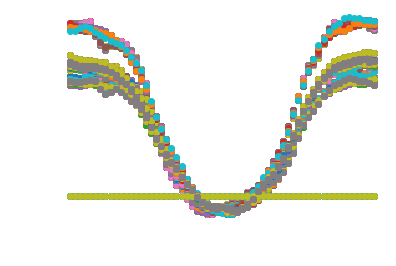

In [22]:
z = 0
for i in range(data['phaseprof'].shape[0]):
    plt.plot(data['vabsfine'], data['phaseprof'][i], 'o')
    if np.nanmedian(data['phaseprof'][i]) == 0:
        z += 1

In [23]:
c_phase_bins = np.arange(0.15,1.25,0.025)
d_phase_bins = np.arange(1.2,2.1,0.025)

def bin_to_phase(bins):
    binned_grid = np.zeros( (len(bins), data['phaseprof'].shape[-1])  )
    for i in range(len(bins)-1):
        inds = np.where((data['yphase']>=bins[i]) &
                        (data['yphase']<bins[i+1]))[0]
        med = np.nanmedian(data['phaseprof'][inds], axis=0)
        binned_grid[i] = med #- np.nanmean(data['phaseprof'], axis=0)
    return binned_grid

#d_binned_grid = bin_to_phase(d_phase_bins)
c_binned_grid = bin_to_phase(c_phase_bins)

//anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [24]:
def plot_waterfall(phase_bins, binned_grid, planet, highlight=80,
                   vmin=-0.1, vmax=0.1):
    clist = np.array(['#000000', 
                      parula_colors[highlight],
                      '#FFFFFF'
                      ])
    rgb_tuples = []

    for c in clist:
        rgb_tuples.append(hex_to_rgb(c))

    cm = LinearSegmentedColormap.from_list(
            'sequential', rgb_tuples, N=2048)

    plt.rcParams['font.size'] = 20
    highlight_color = 'k'

    plt.figure(figsize=(12,5))
    plt.imshow(binned_grid, vmin=vmin, vmax=vmax, cmap=cm)
    plt.colorbar(label='Fractional Deviation')

    # HANDLES X-AXIS AND VERTICAL LINES
    xinterp = interp1d(data['vabsfine'],
                      np.arange(0,binned_grid.shape[-1],1))
    xticks = [-40, -20, 0, 20, 40]

    vsini = 24.233951
    plt.vlines(xinterp(vsini), -10, 100, color=highlight_color, 
               linestyle='--',
               linewidth=3)
    plt.vlines(xinterp(-vsini), -10, 100, color=highlight_color, 
               linestyle='--',
               linewidth=3)
    plt.xticks(xinterp(xticks),
               labels=xticks)

    # HANDLES Y-AXIS AND HORIZONTAL LINES
    if planet == 'c':
        yinterp = interp1d(phase_bins,
                           np.arange(0,binned_grid.shape[0],1))
        yticks = np.arange(0.2, 1.4, 0.2)
        plt.hlines(yinterp(0.5), 0, 64, color=highlight_color, 
                   linestyle='--',
                   linewidth=3)
        plt.yticks(yinterp(yticks),
                   labels=np.round(yticks,1))

    plt.ylim(0,len(phase_bins)-2.5)
    plt.xlabel('Velocity [km s$^{-1}$]', fontsize=26)
    plt.ylabel('Transit Phase', fontsize=26)
    #plt.savefig('/Users/arcticfox/Desktop/waterfall.png', dpi=300,
    #            rasterize=True, bbox_inches='tight', transparent=True)

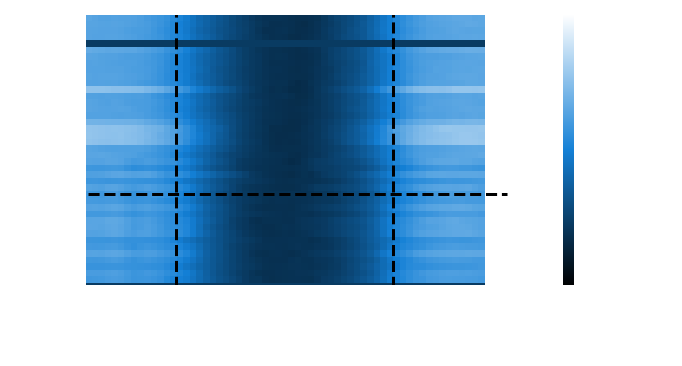

In [29]:
plot_waterfall(c_phase_bins, c_binned_grid, planet='c', 
               highlight=60, vmin=-0.3, vmax=1)

In [73]:
#look at changes in H-alpha and sodium and see if those change with the 
#     features in the waterfall plot

# back out the RVs from the waterfall plot
#      cross correlate each epoch with a time-averaged template
#      use more bins

# re-reducing GRACES data with veloce technique for better understanding
#      halpha and sodium

## Backing out RVs

In [13]:
template = np.nanmedian(data['phaseprof'], axis=0)

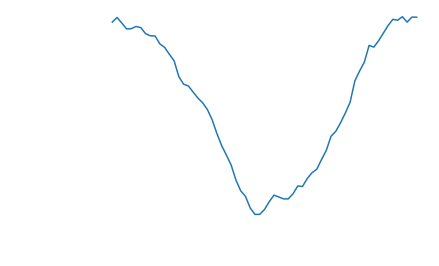

In [14]:
plt.plot(template-np.nanmax(template))

In [15]:
def cross_correlate(dat, plot=False):
    global template

    xcorrs = np.zeros((len(dat), len(template)))
    peaks  = np.zeros(len(dat))

    for i in range(len(dat)):

        corr = np.correlate(template - np.nanmax(template), 
                            dat[i] - np.nanmax(dat[i]), 
                            mode='same')

        c = np.arange(np.argmax(corr)-10, np.argmax(corr)+10,1,dtype=int)

        fit = np.polyfit(c-np.argmax(corr), corr[c], deg=2)
        maximum = -fit[1]/(2*fit[0]) # pixel units

        if plot:
            fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,6))
            ax1.plot(data['vabsfine'], template, 'k', lw=2)
            ax1.plot(data['vabsfine'], data['phaseprof'][i], c=parula_colors[i*3])
            ax2.plot(c-np.argmax(corr), corr[c], c=parula_colors[i*3])
            plt.show()

        xcorrs[i] = corr
        peaks[i] = maximum
    
    return xcorrs, peaks

In [16]:
bins = np.linspace(0.15,1.25, len(data['vabsfine']))
binned_grid = bin_to_phase(bins)

//anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


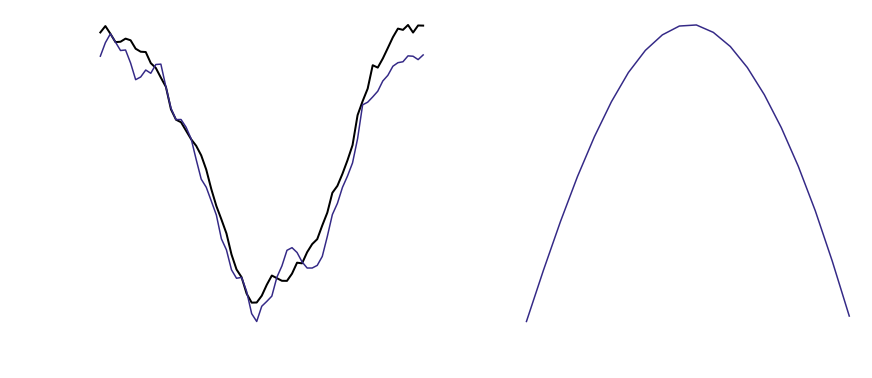

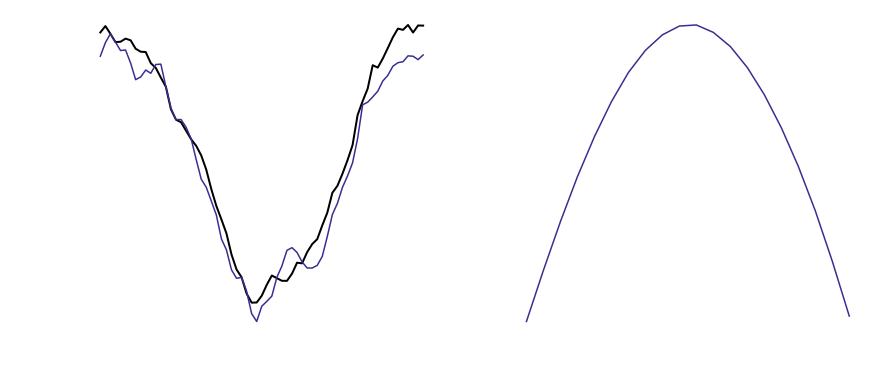

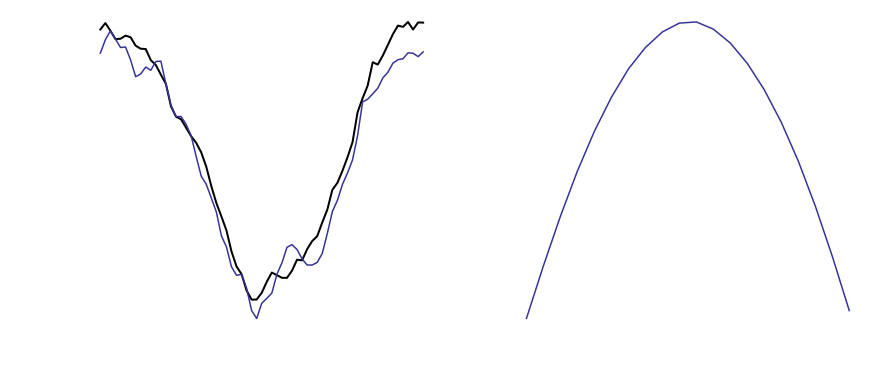

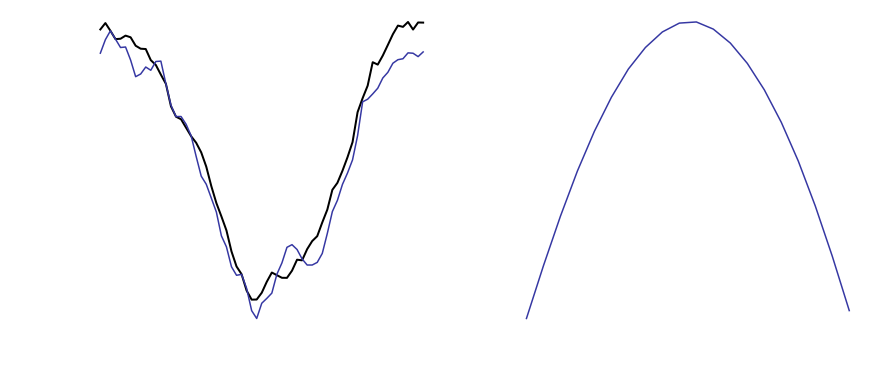

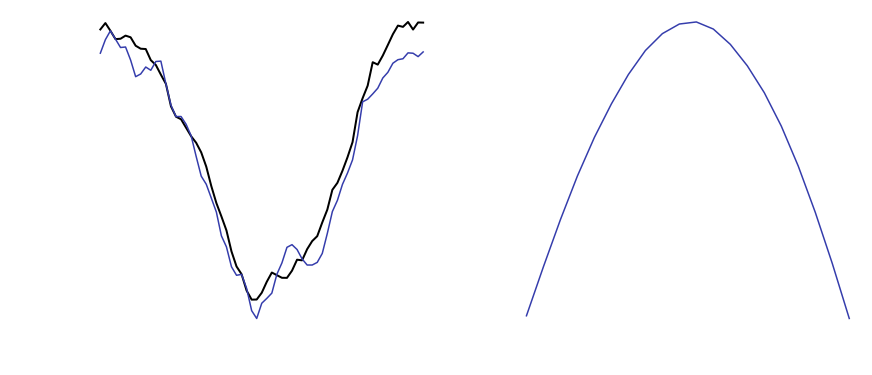

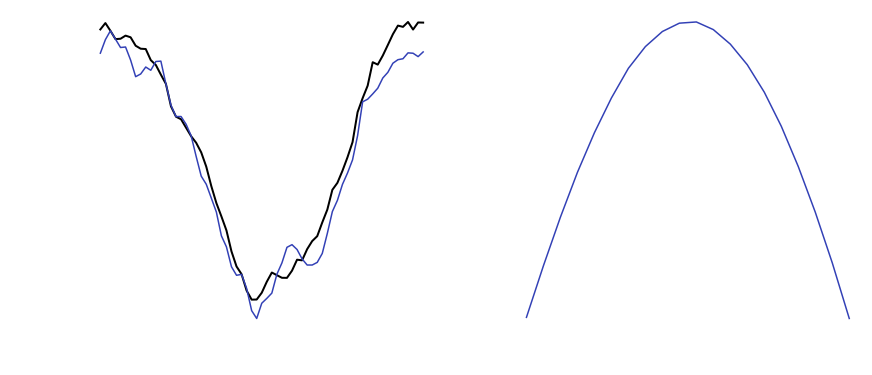

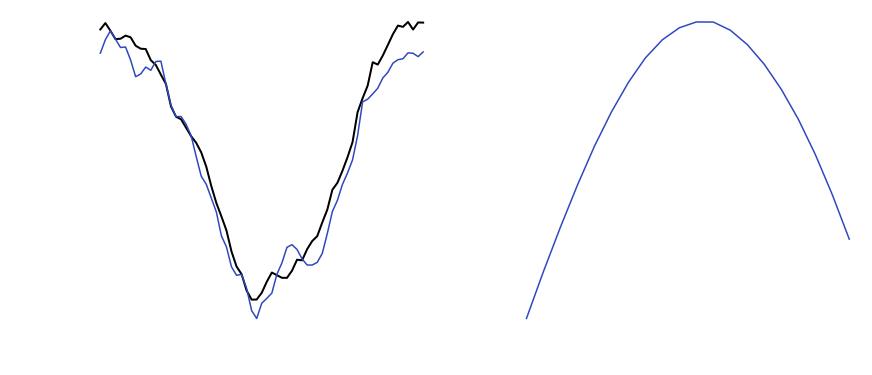

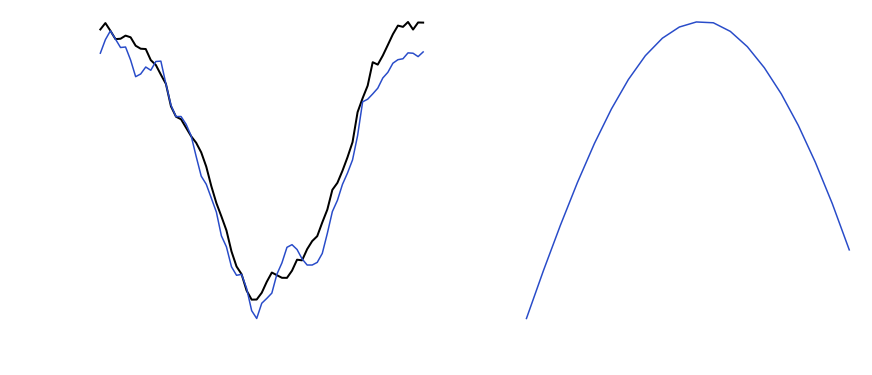

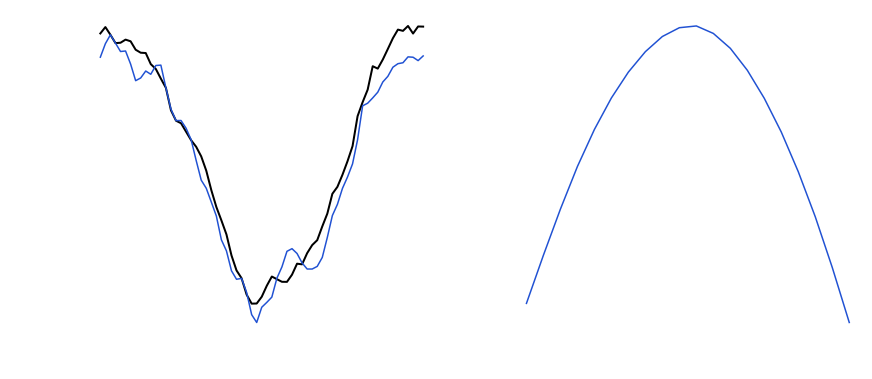

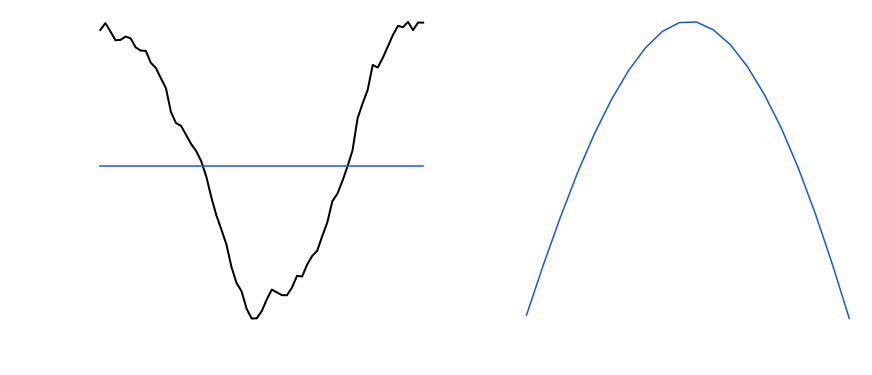

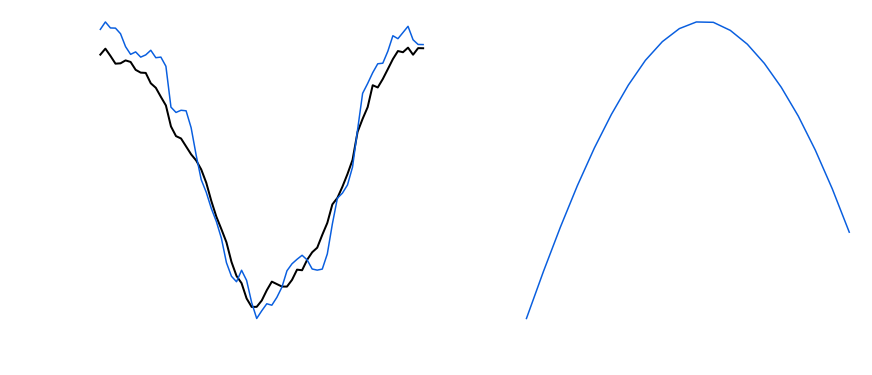

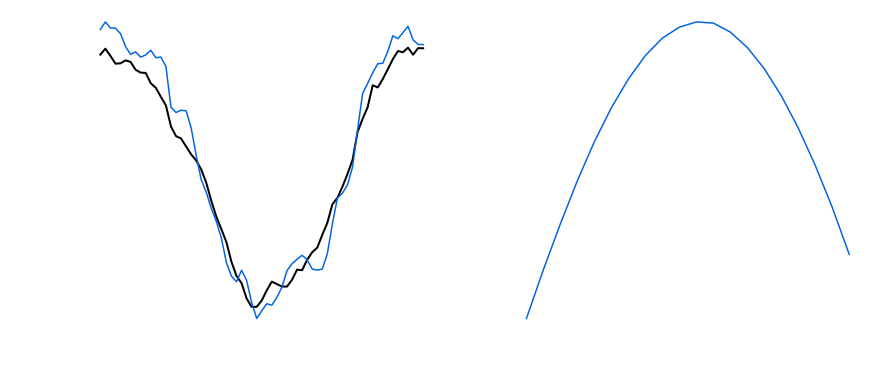

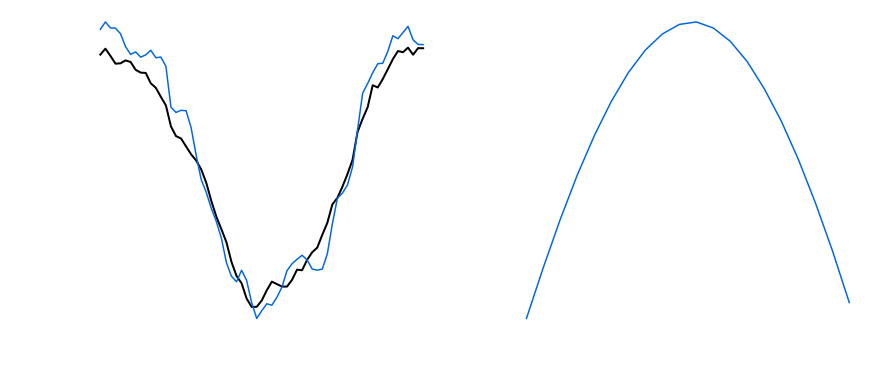

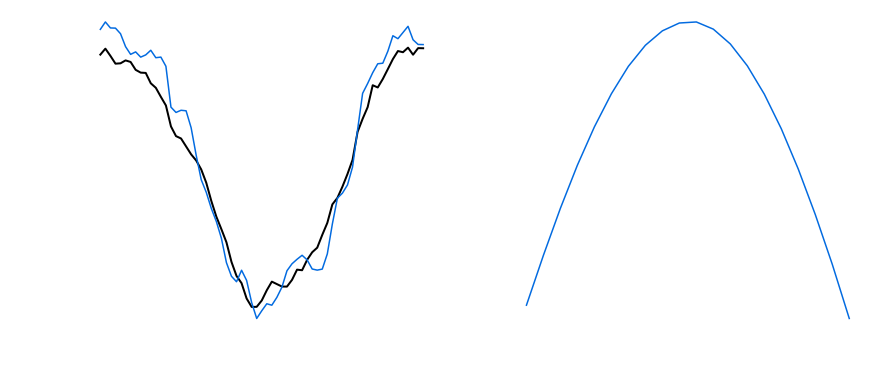

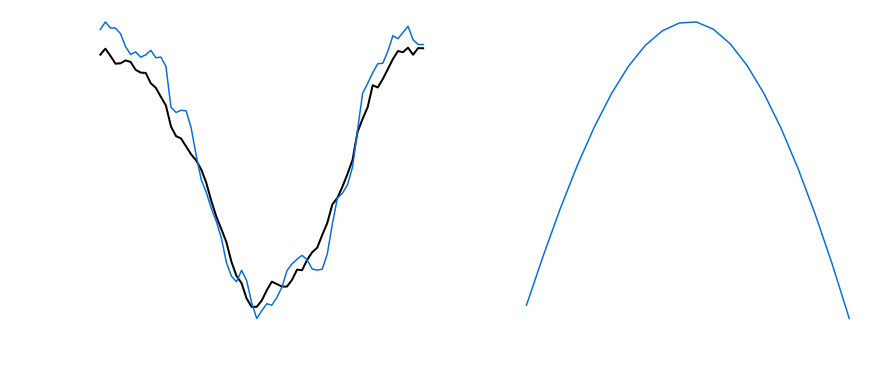

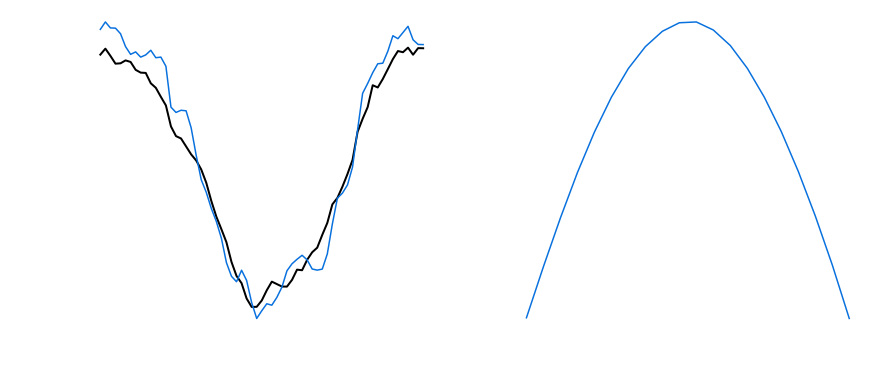

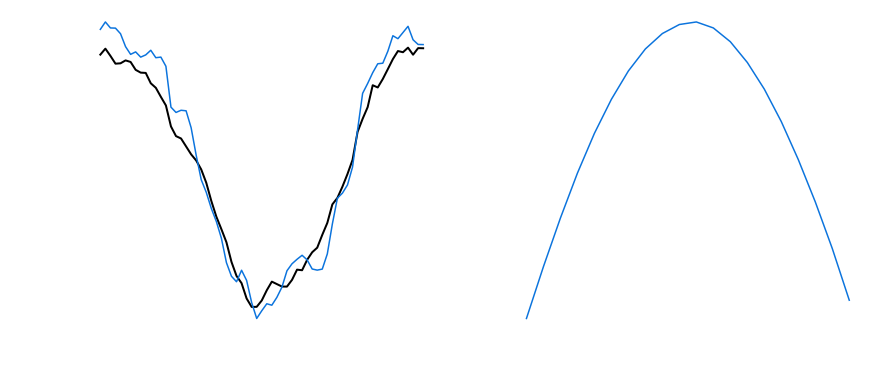

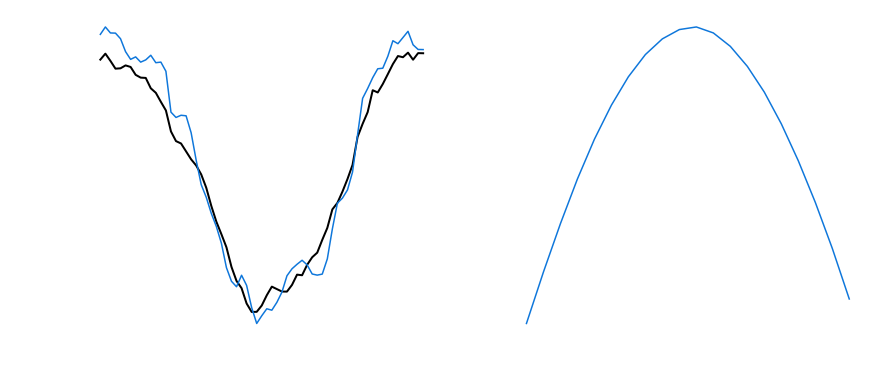

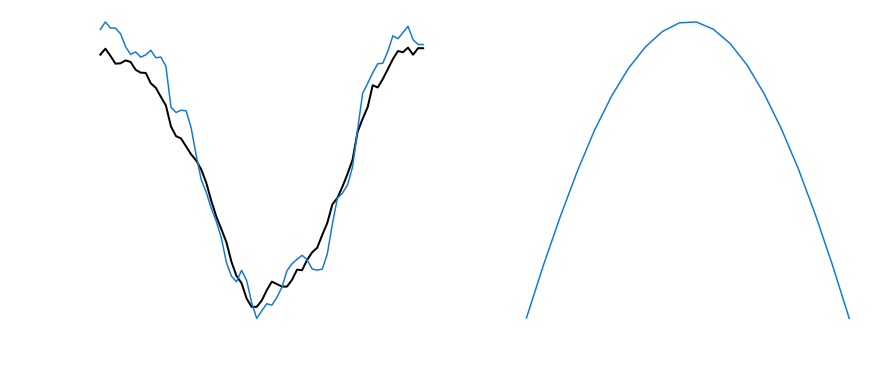

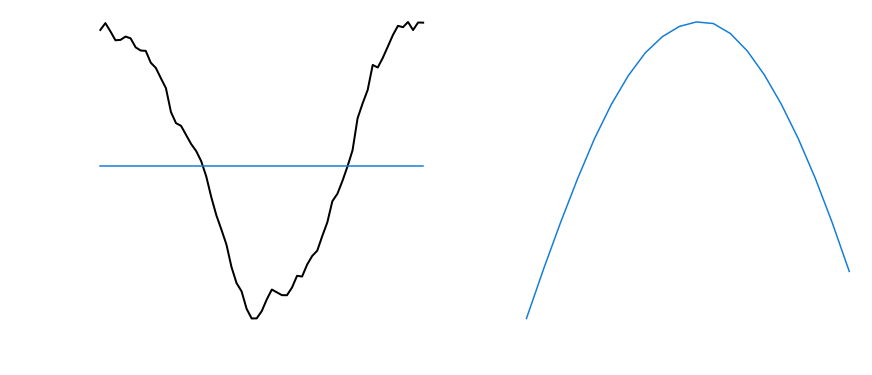

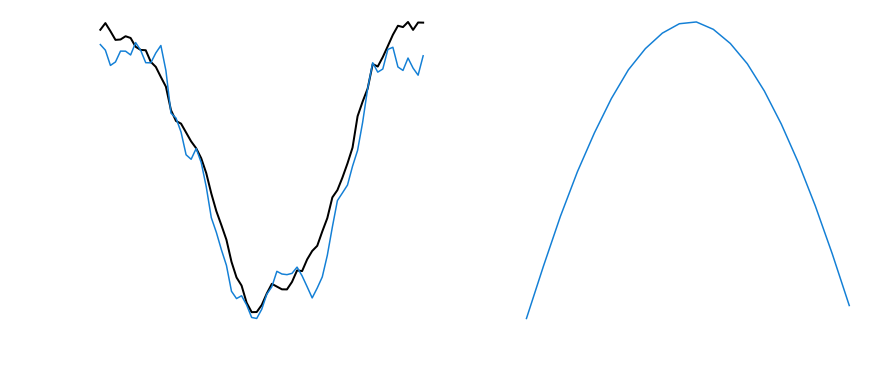

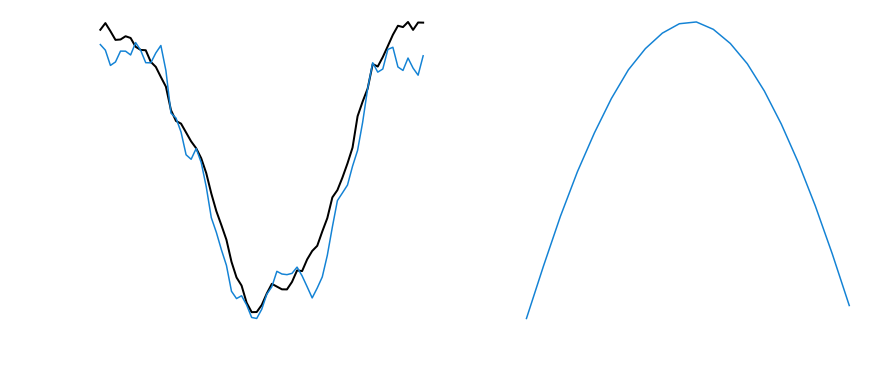

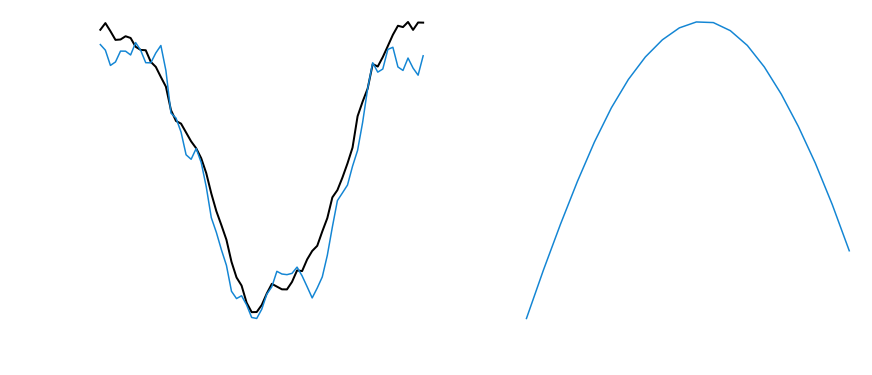

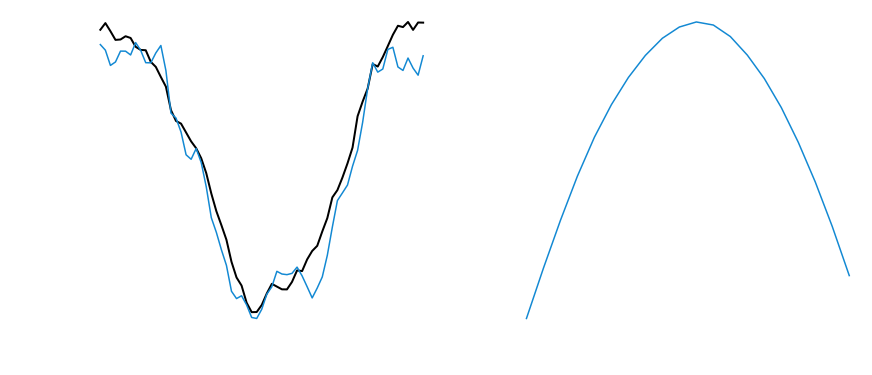

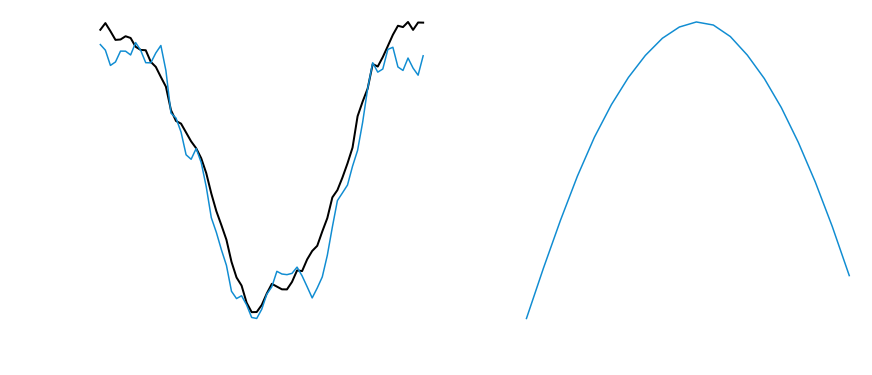

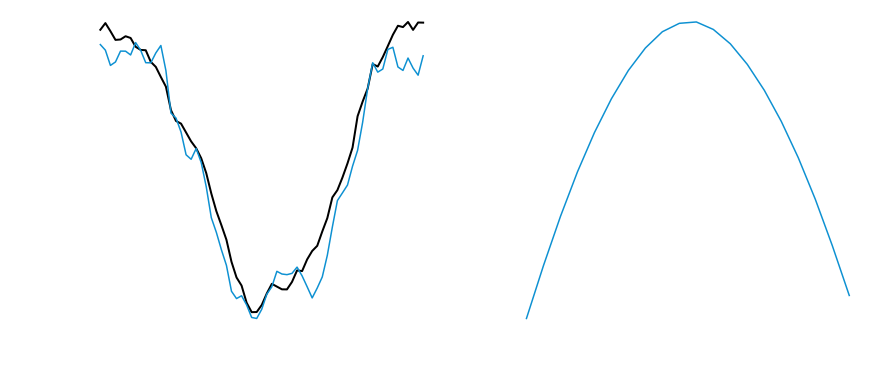

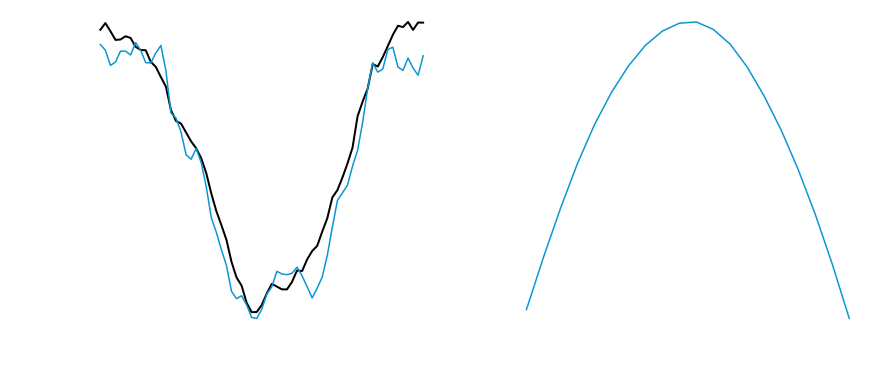

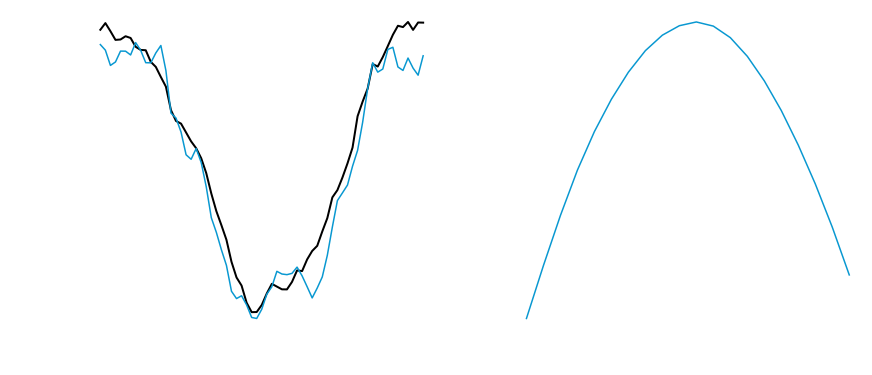

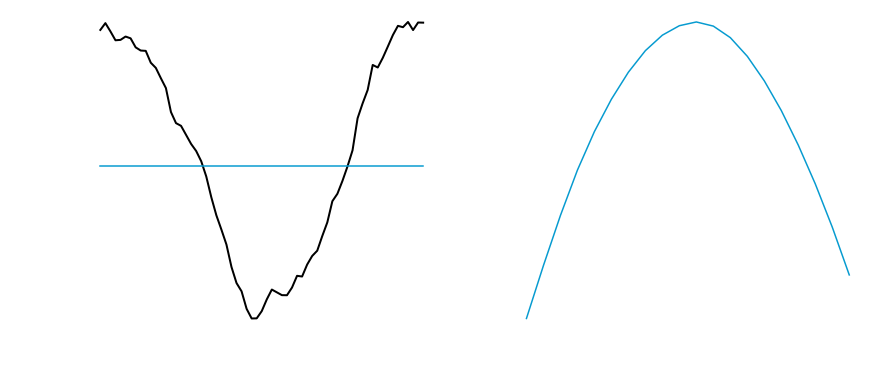

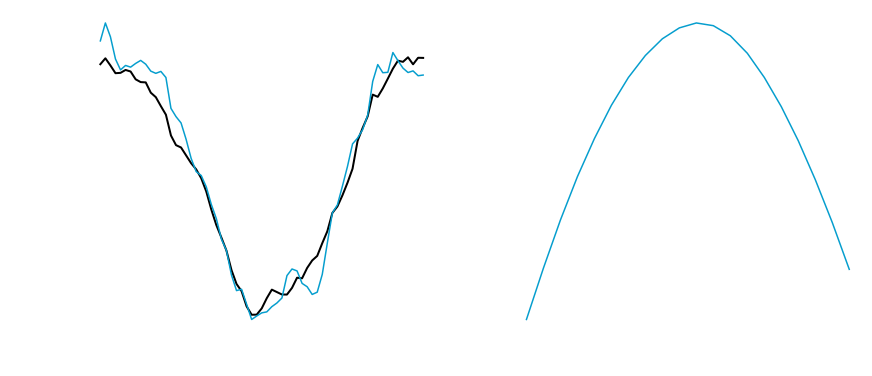

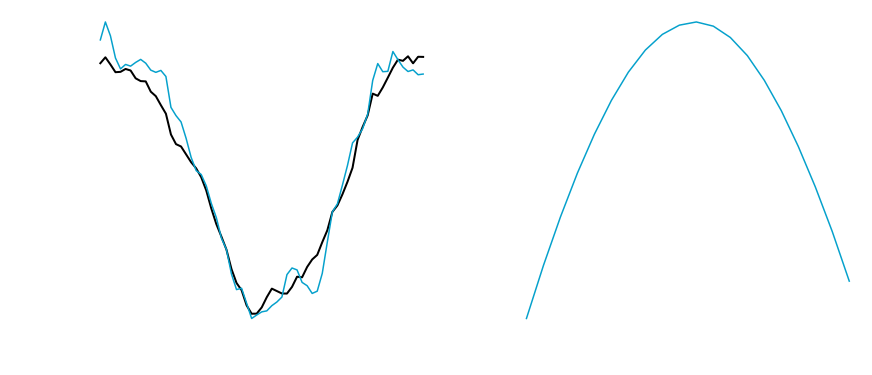

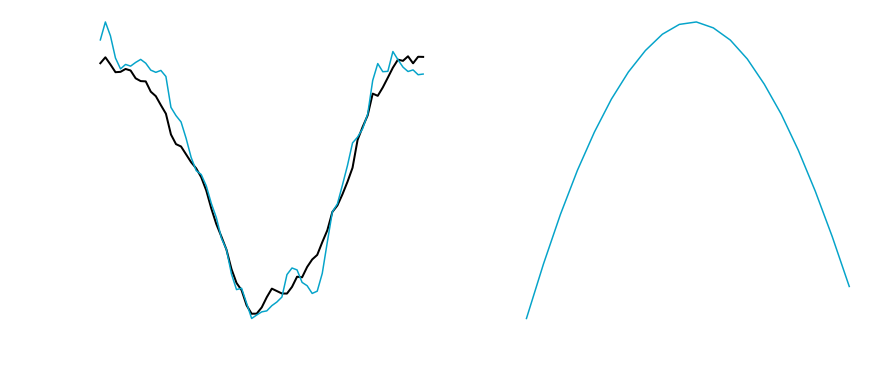

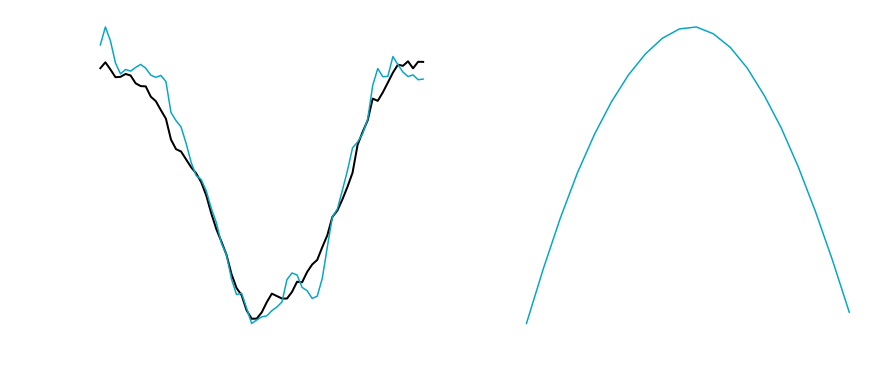

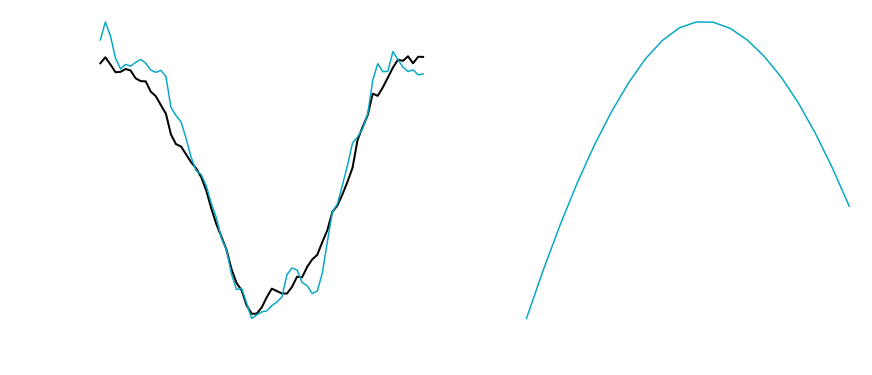

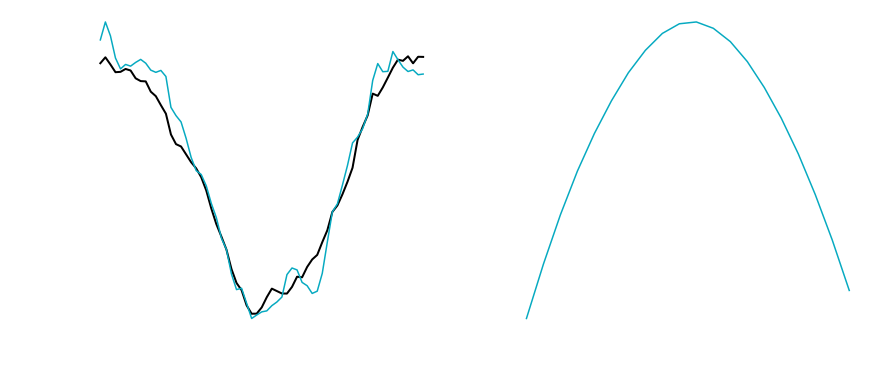

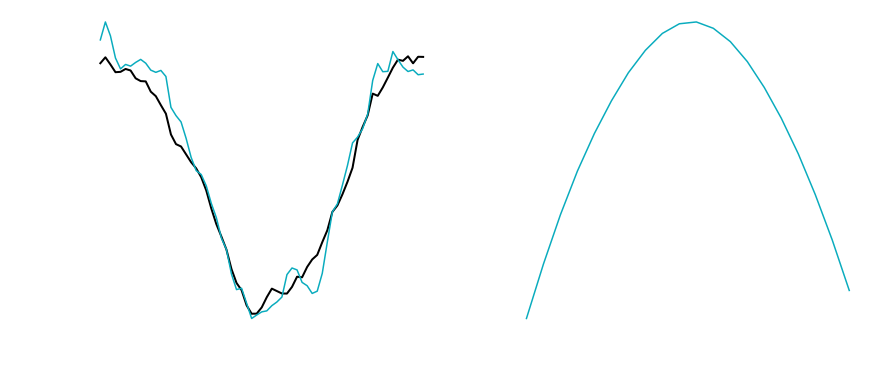

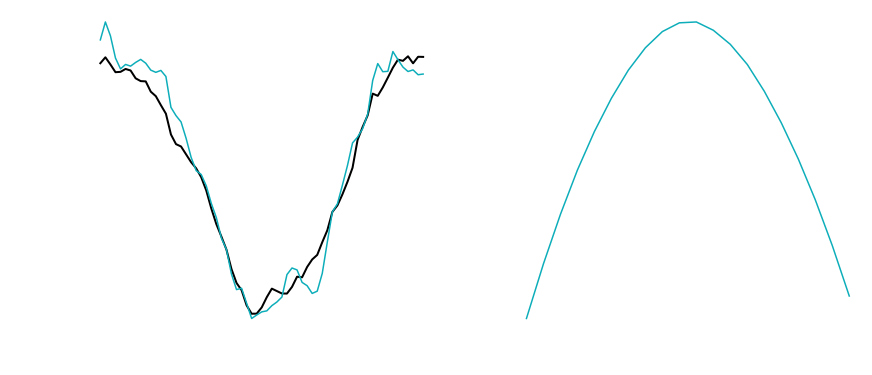

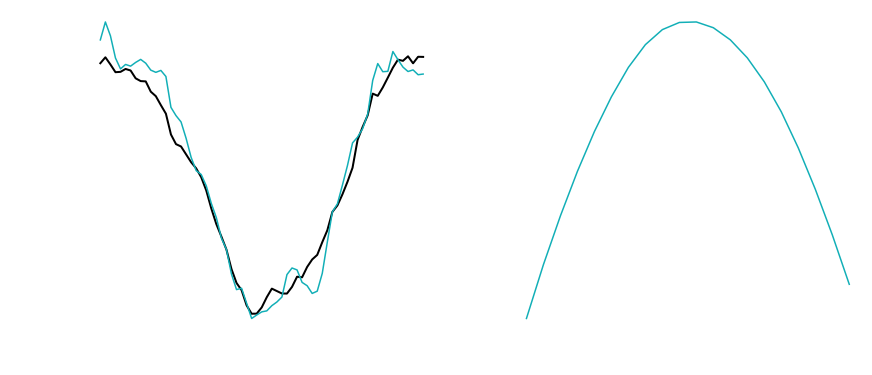

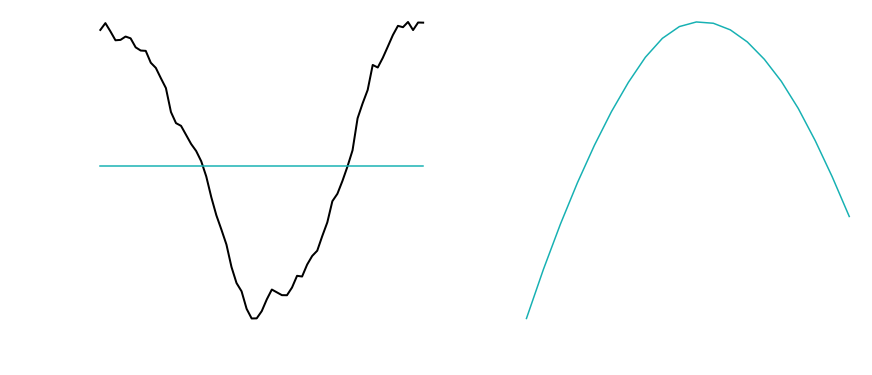

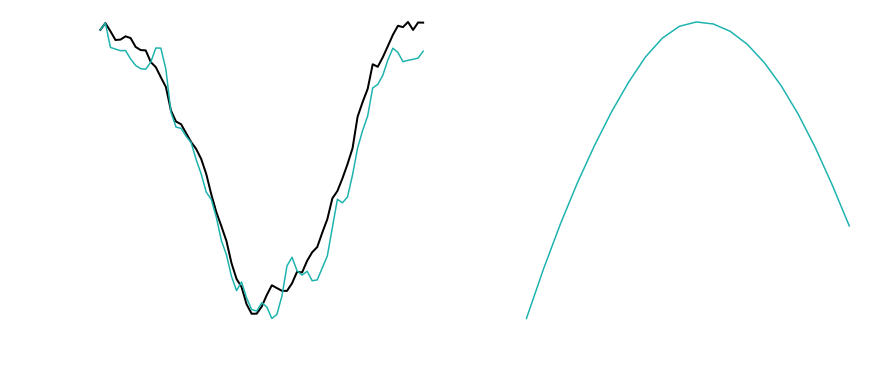

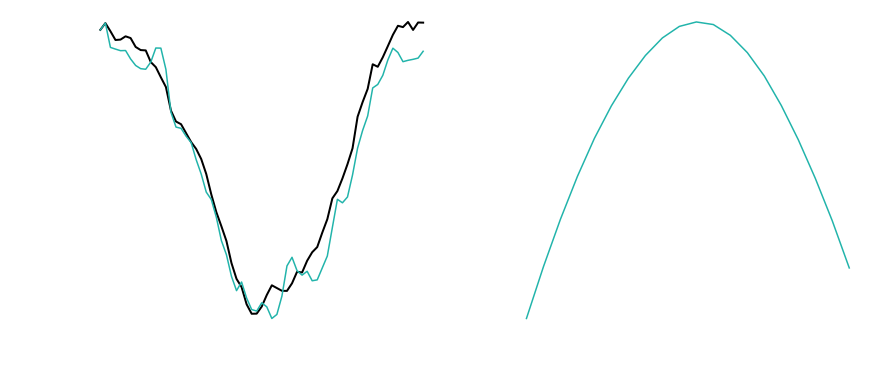

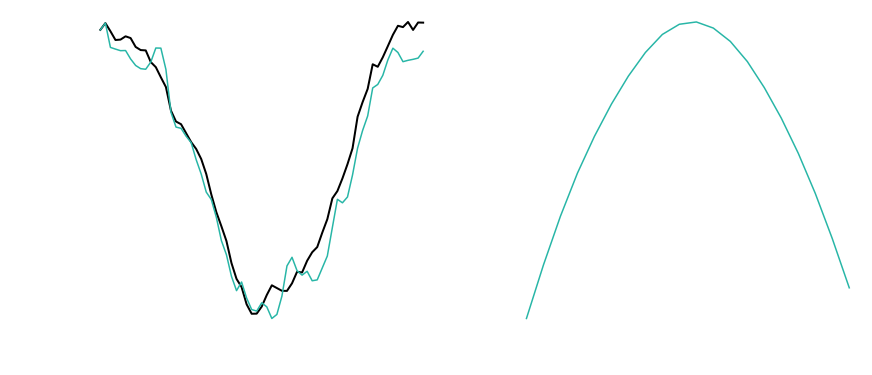

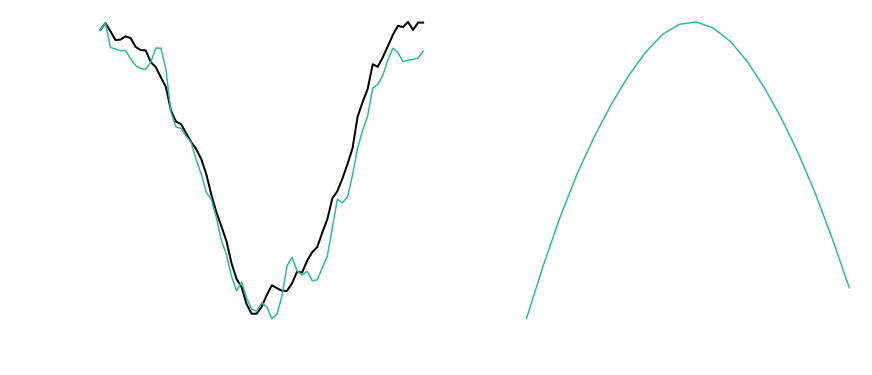

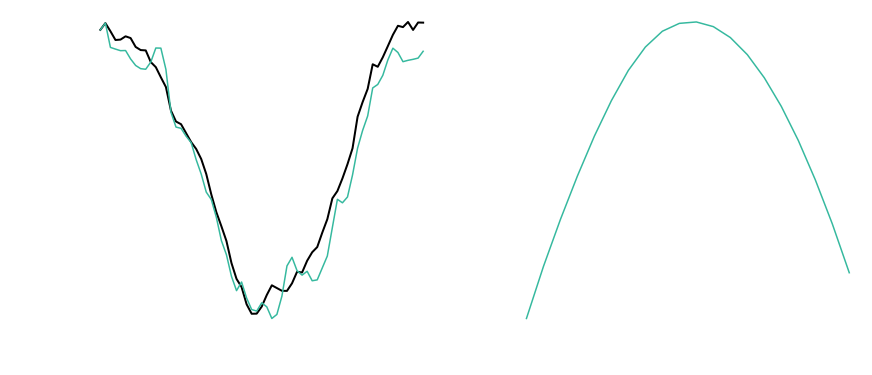

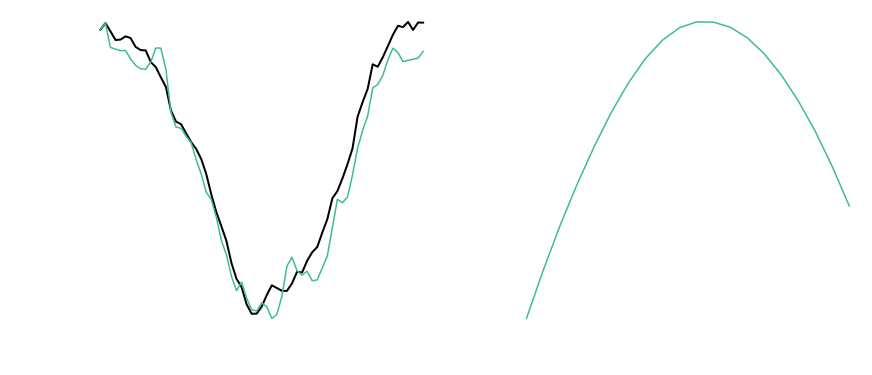

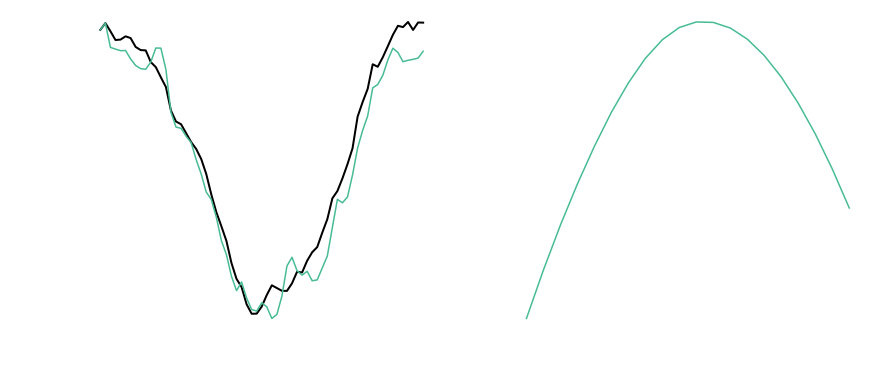

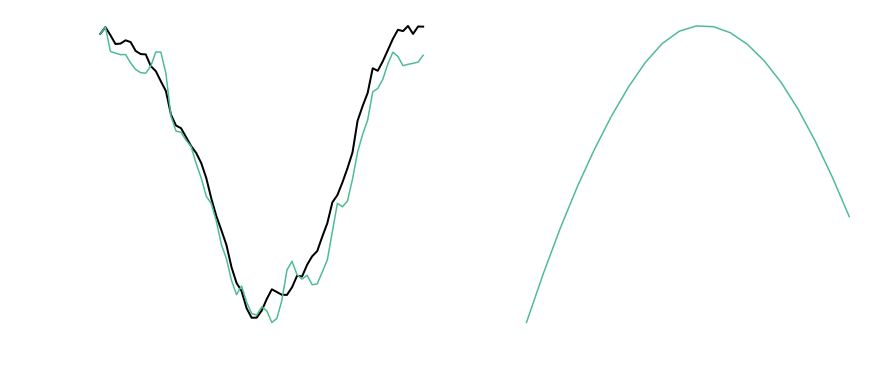

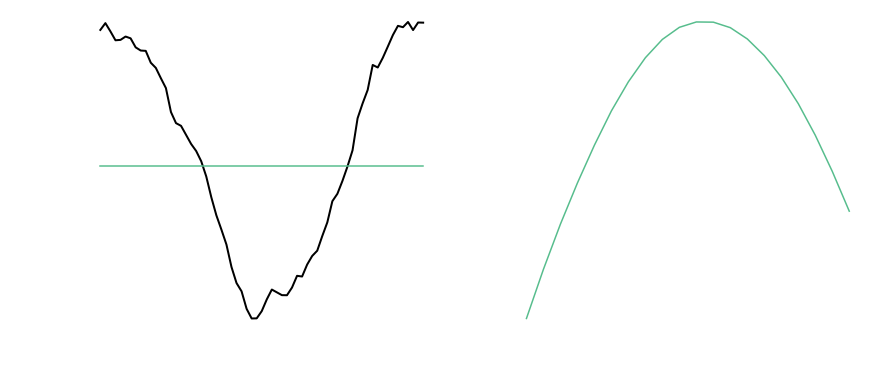

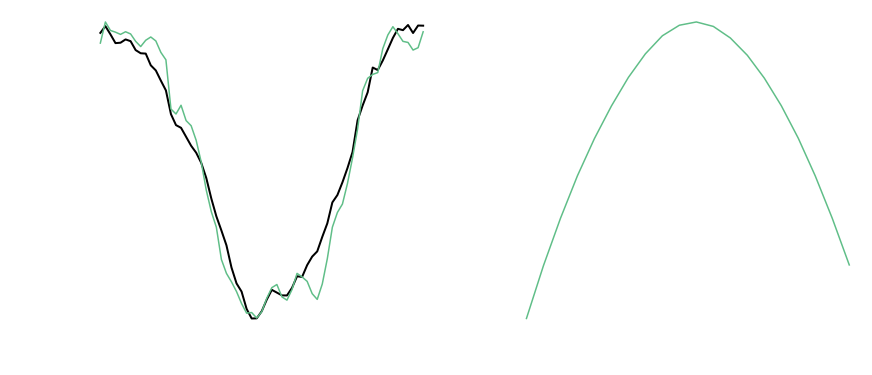

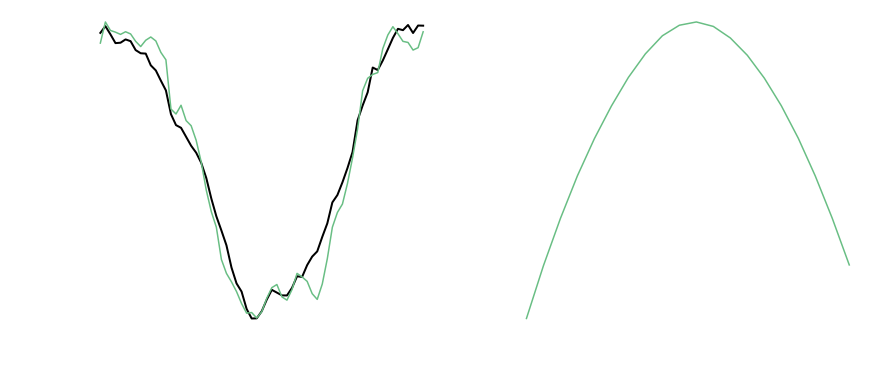

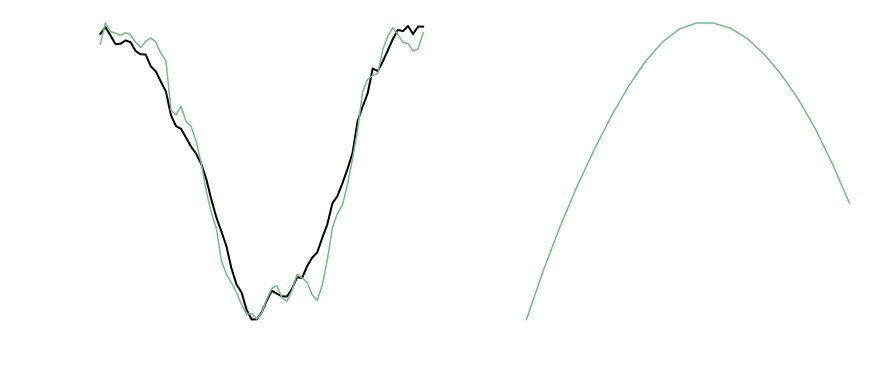

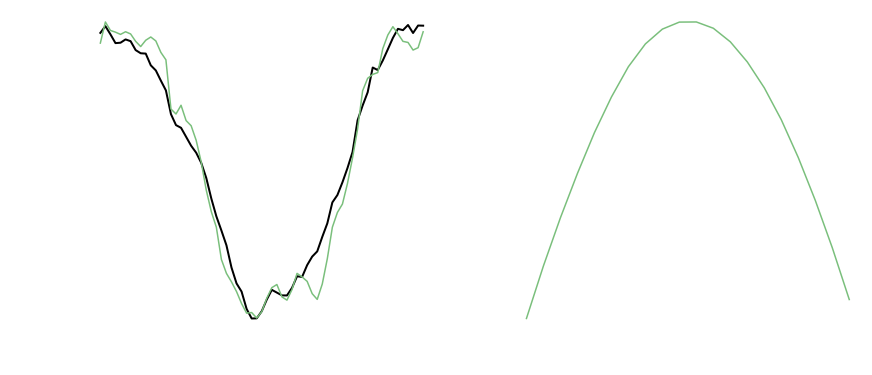

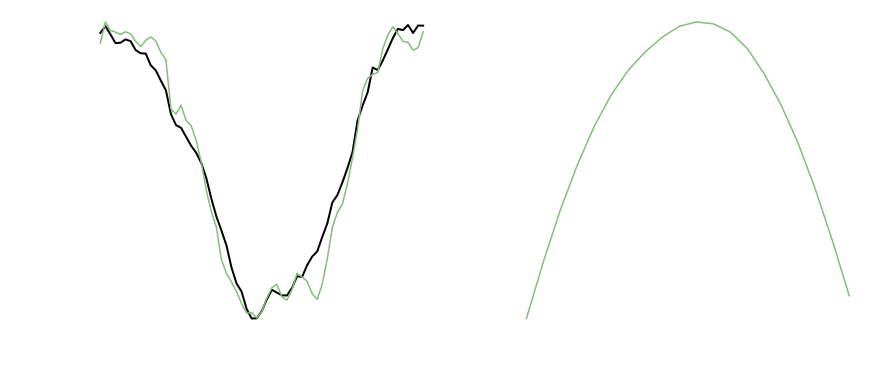

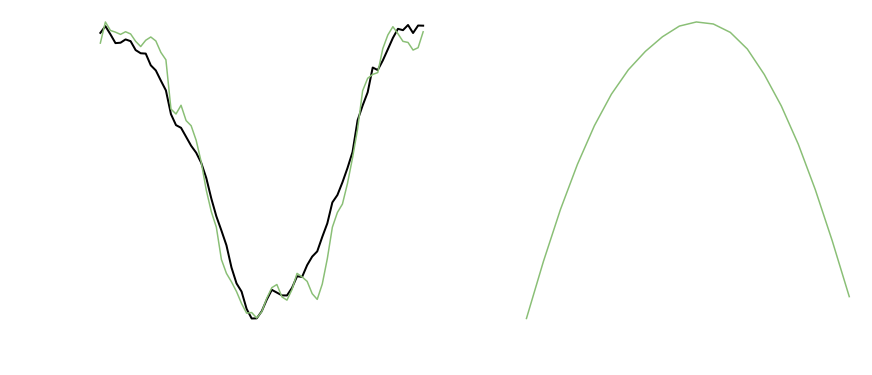

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


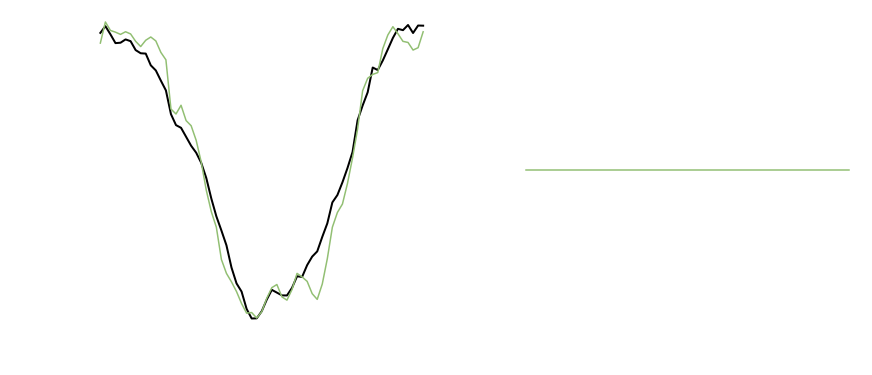

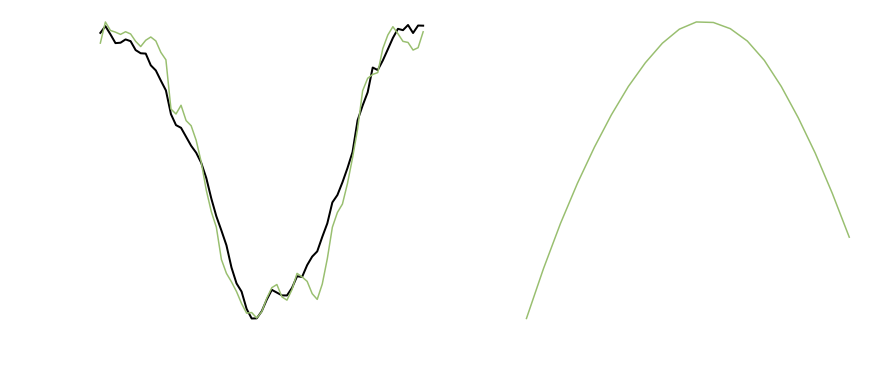

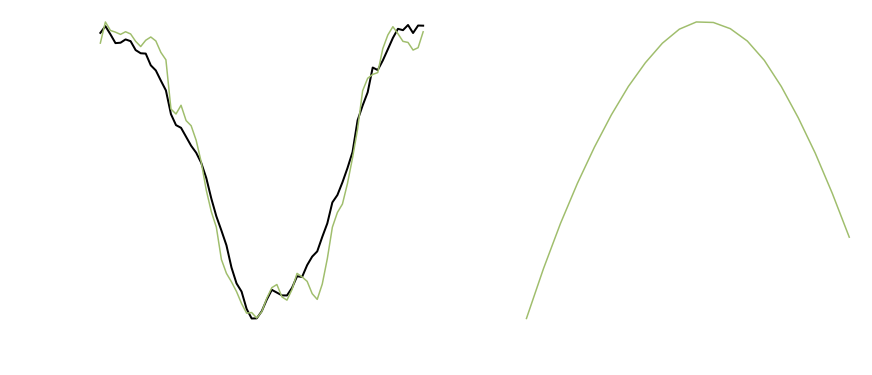

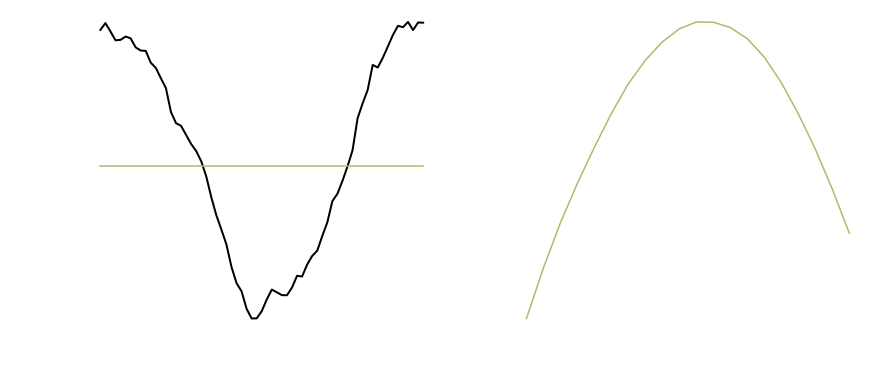

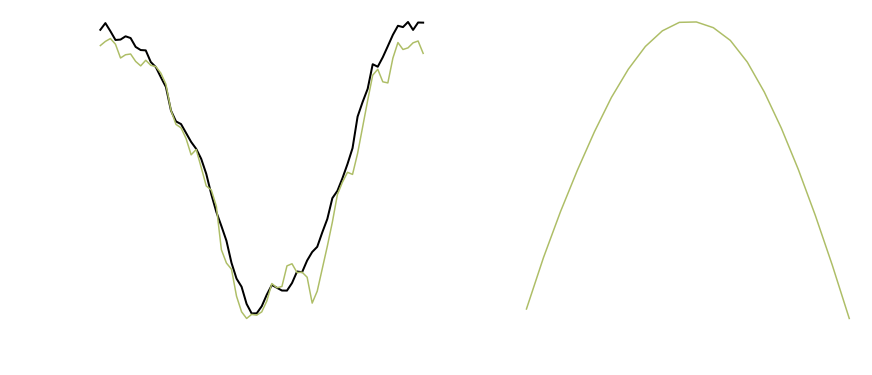

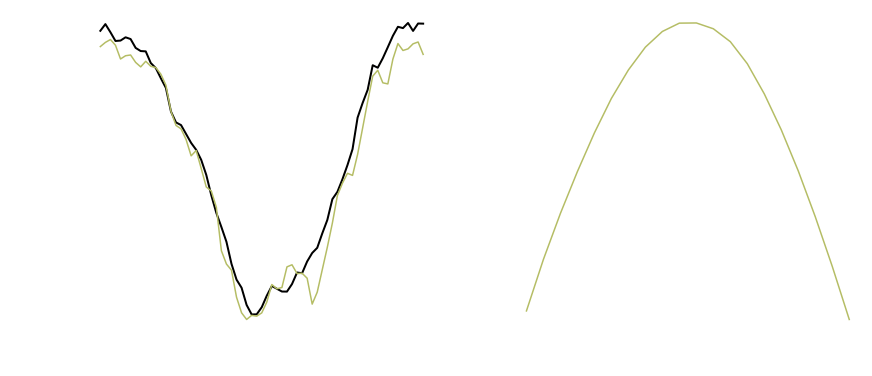

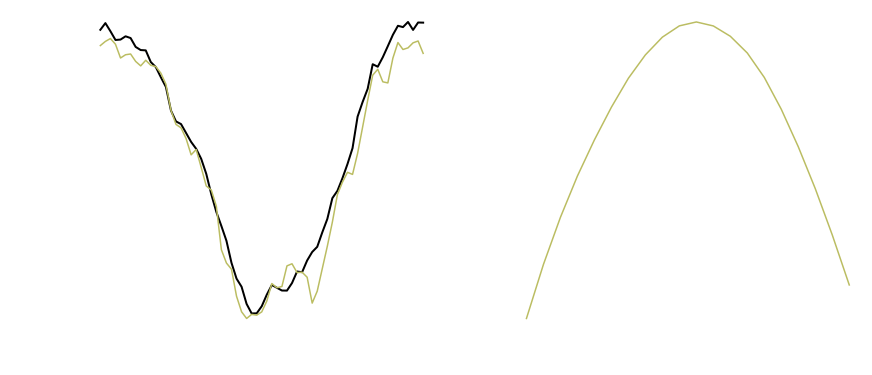

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: All-NaN slice encountered
  # Remove the CWD from sys.path while we load stuff.


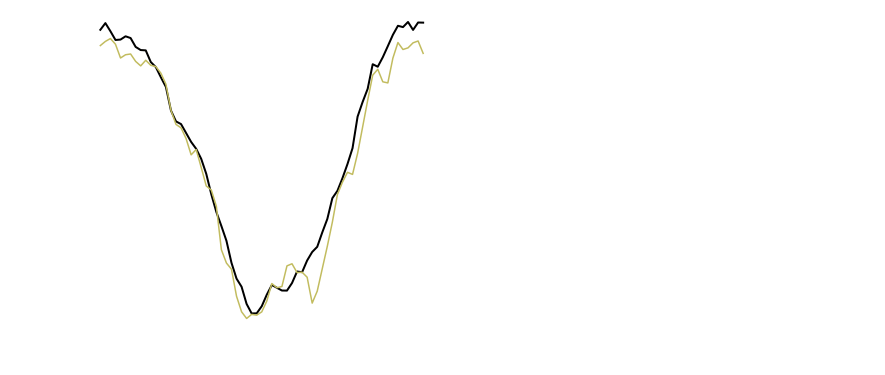

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: All-NaN slice encountered
  # Remove the CWD from sys.path while we load stuff.


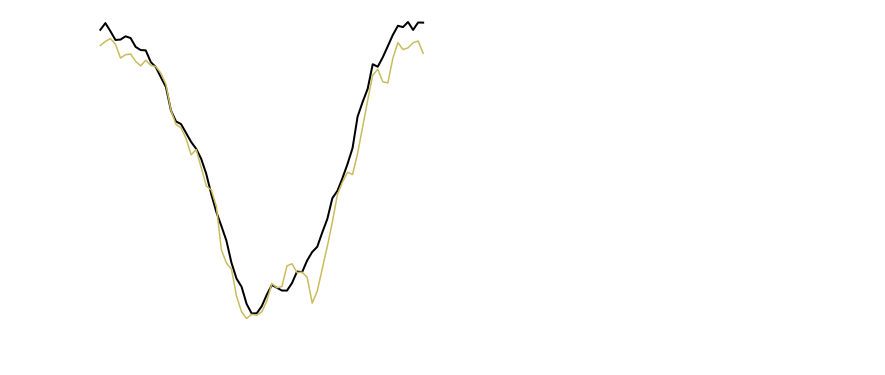

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: All-NaN slice encountered
  # Remove the CWD from sys.path while we load stuff.


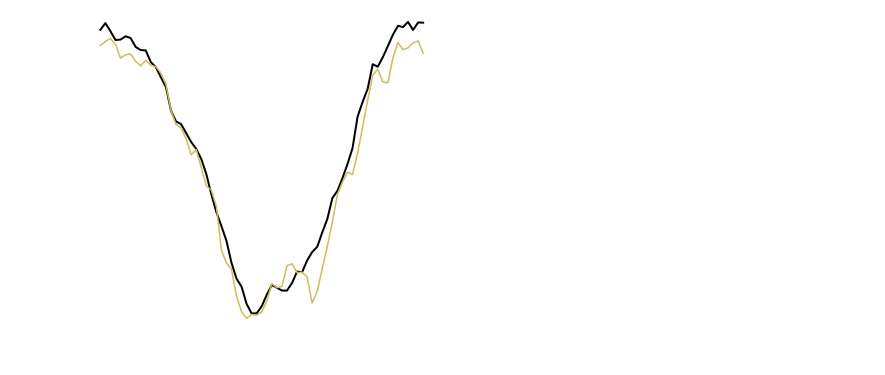

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


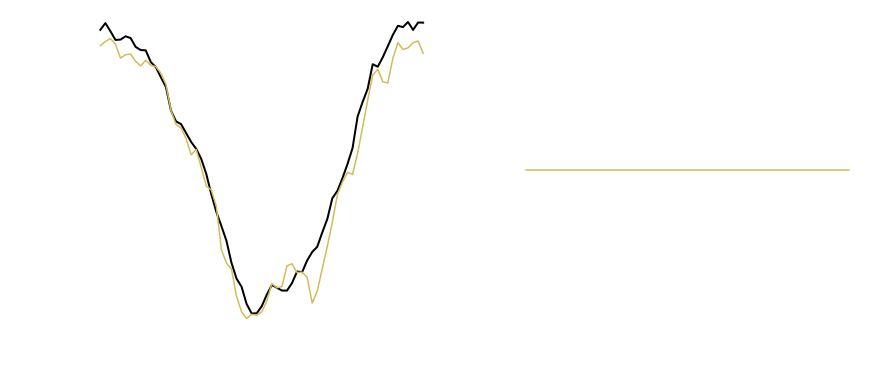

In [17]:
xcorrs, peaks = cross_correlate(binned_grid, plot=True)

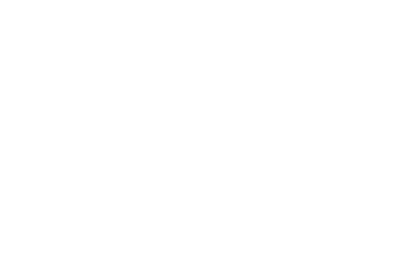

In [18]:
plt.plot(peaks*data['vabsfine'], 'w.')